# [CoE202] note 07a. Neural Network (Pytorch)

- Class Date : 21.05.06.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

In [2]:
# this is just an annotation
import numpy as np # this is for importing numpy library (and we will use abbreviation np for that)
import matplotlib.pyplot as plt # this is for importing matplotlib.pyplot (library for graph plot)
import torch # import PyTorch
import scipy.io
import numpy as np

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")
# mat = scipy.io.loadmat('/content/drive/My Drive/01_LectureNotes/CoE202/Colab/data/data_nonlinear_classification3.mat')
mat = scipy.io.loadmat('./data_nonlinear_classification3.mat')

data = mat['data']
label = mat['label']

## 1-1. Data Load and split into train, valid and test set

#### 1000 data to 700, 150, 150 for train, valid and test set each.

In [4]:
data = torch.from_numpy(data) 
label = torch.from_numpy(label)

In [5]:
print(data.size())
print(label.size())

torch.Size([2, 1000])
torch.Size([1, 1000])


In [6]:
(train_index, valid_index, test_index) = torch.split(torch.randperm(1000), [700, 150, 150])
train_data, train_label = data[:, train_index], label[:, train_index]
valid_data, valid_label = data[:, valid_index], label[:, valid_index]
test_data, test_label = data[:, test_index], label[:, test_index]

print(train_data.size(), train_label.size())
print(valid_data.size(), valid_label.size())
print(test_data.size(), test_label.size())

torch.Size([2, 700]) torch.Size([1, 700])
torch.Size([2, 150]) torch.Size([1, 150])
torch.Size([2, 150]) torch.Size([1, 150])


## 1-2. visualization

In [7]:
# define a function to plot data
def show_data(data, label):
    ind = 0
    for color in ['tab:blue', 'tab:orange']:
        current_ind = (label == ind)[0]  # Find index where is class 0, class 1
        x = data[0, current_ind]  # Find x, y location from index
        y = data[1, current_ind]
        plt.scatter(x, y, c=color, edgecolors='none')  # Show dot at (x, y) with corresponding color
        ind +=1  # change to next class index    

ground truth


Text(0.5, 1.0, 'Test dataset')

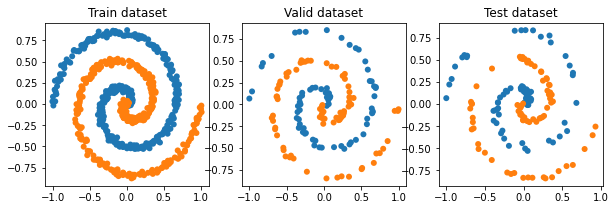

In [8]:
# show ground truth classification
plt.figure(figsize=[10, 3])
plt.subplot(1, 3, 1)
print('ground truth')
show_data(train_data, train_label)
plt.title("Train dataset")
plt.subplot(1, 3, 2)
show_data(valid_data, valid_label)
plt.title("Valid dataset")
plt.subplot(1, 3, 3)
show_data(test_data, test_label)
plt.title("Test dataset")

## 2. Build MLP classifier and show initial classification

#### 4 - layer MLP

In [9]:
# Define MLP classifier
class mlp_classifier(torch.nn.Module):
    '''2 Layer Multi-Layer Perceptron can be easily implemented by Linear layer of Pytorch.
    The linear layer has weight matrix and bias matrix. We will first initialize this weight and bias
    as following normal distribution, by 'weights_init' function. 
    '''
    # initialization
    def __init__(self):
        super(mlp_classifier, self).__init__()
        self.layer1 = torch.nn.Linear(2, 10)
        self.layer2 = torch.nn.Linear(10, 10)
        self.layer3 = torch.nn.Linear(10, 10)
        self.layer4 = torch.nn.Linear(10, 1)
        self.relu = torch.nn.ReLU()
        self.sig = torch.nn.Sigmoid()
    
    # forward path
    def forward(self, x):
        # Used relu to add non-linearity
        x = self.layer1(x) # matrix multiplication
        x = self.relu(x) # activation
        x = self.layer2(x)  # matrix multiplication
        x = self.relu(x) # activation
        x = self.layer3(x) # matrix multiplication
        x = self.relu(x) # activation
        x = self.layer4(x) # matrix multiplication
        x = self.sig(x) #  SIGMOID
        return x
    

def calc_accuracy(prediction, label):
    # Calculate accuracy 
    num_data = prediction.size(0)
    prediction_thresholding = thresholding(prediction)
    
    accuracy = (prediction_thresholding[:, 0] == label[0, :]).sum().item() / num_data

    return accuracy

def thresholding(prediction):
    # Make one-hot encoding from raw prediction of classifier by softmax
    return (prediction>0.5).float()


current classification


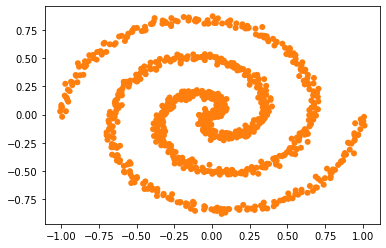

In [10]:
my_classifier = mlp_classifier() 

# show the performance of untrained classifier
print('current classification')
prediction = my_classifier(data.permute(1, 0))          
show_data(data, thresholding(prediction).permute(1, 0))  

## 3. Train with train set & monitor loss and accuracy for train, valid and test set

In [11]:
# set hyper parameters
n_iter = 10000
learning_rate = 0.001

#  numpy array to save loss from each epoch
train_loss_iter, valid_loss_iter, test_loss_iter = np.zeros(n_iter, dtype=float), np.zeros(n_iter, dtype=float), np.zeros(n_iter, dtype=float)

# numpy array to save accuracy from each epoch
train_accuracy_iter, valid_accuracy_iter, test_accuracy_iter = np.zeros(n_iter, dtype=float), np.zeros(n_iter, dtype=float), np.zeros(n_iter, dtype=float)

# We are going to use Binary cross entropy loss (built in Pytorch!)
criterion = torch.nn.BCELoss()

# We can use either SGD or Adam (and there are other choices as well)
#optimizer = torch.optim.SGD(my_classifier.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(my_classifier.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)



# main iteration
for iter in range(n_iter):  
    
    # training
    prediction = my_classifier(train_data.permute(1, 0))  # Forward pass (of training data)
    
    optimizer.zero_grad()  # Pytorch does not overwrite gradients, but it 'accumulates' them. Thus, we need to set gradient as 0 before we start.

    loss = criterion(prediction, train_label.permute(1, 0))  # Calculate cross-entropy loss 
    loss.backward()  # Pytorch automatically performs back-propagation to calculate gradients
    optimizer.step()  # Using the optimizer and the calculated gradients, update parameters of classifier 

    train_loss_iter[iter] = loss.item() # keep track of the training loss 
    train_accuracy_iter[iter] = calc_accuracy(prediction, train_label) # keep track of the training accuracy

    # validation
    with torch.no_grad(): # we do not need to calculation gradient for validation data
        prediction = my_classifier(valid_data.permute(1, 0)) # Forward pass (of validation data)
        loss = criterion(prediction, valid_label.permute(1, 0)) # Calculate validation loss
        
        valid_loss_iter[iter] = loss.item() # keep track of validation loss
        valid_accuracy_iter[iter] = calc_accuracy(prediction, valid_label) # keep track of validation accuracy

    # print message every 1000 epochs
    if iter % 1000 == 0:
        print(f"[{iter}/{n_iter}] Train Loss : {train_loss_iter[iter]:.4f} Train Acc : {train_accuracy_iter[iter]:.2f} \
        Valid Loss : {valid_loss_iter[iter]:.4f} Valid Acc : {valid_accuracy_iter[iter]:.2f}")

[0/10000] Train Loss : 0.6969 Train Acc : 0.49         Valid Loss : 0.6929 Valid Acc : 0.53
[1000/10000] Train Loss : 0.3817 Train Acc : 0.80         Valid Loss : 0.3857 Valid Acc : 0.80
[2000/10000] Train Loss : 0.3580 Train Acc : 0.80         Valid Loss : 0.3621 Valid Acc : 0.81
[3000/10000] Train Loss : 0.3550 Train Acc : 0.80         Valid Loss : 0.3608 Valid Acc : 0.81
[4000/10000] Train Loss : 0.3539 Train Acc : 0.80         Valid Loss : 0.3619 Valid Acc : 0.81
[5000/10000] Train Loss : 0.3533 Train Acc : 0.80         Valid Loss : 0.3632 Valid Acc : 0.81
[6000/10000] Train Loss : 0.3528 Train Acc : 0.80         Valid Loss : 0.3619 Valid Acc : 0.81
[7000/10000] Train Loss : 0.3526 Train Acc : 0.80         Valid Loss : 0.3602 Valid Acc : 0.81
[8000/10000] Train Loss : 0.3524 Train Acc : 0.80         Valid Loss : 0.3597 Valid Acc : 0.81
[9000/10000] Train Loss : 0.3523 Train Acc : 0.80         Valid Loss : 0.3588 Valid Acc : 0.81


In [12]:
print(train_data.permute(1, 0).shape)

torch.Size([700, 2])


## 4-1. Plot loss and accuracy of train, valid and test set for epoch

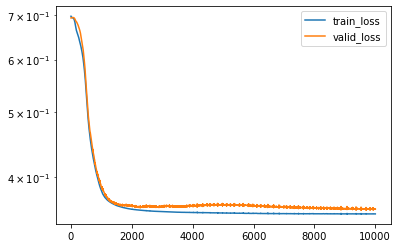

In [13]:
# plot loss curve
l1, = plt.semilogy( range(1,n_iter+1), train_loss_iter)
l2, = plt.semilogy( range(1,n_iter+1), valid_loss_iter)

plt.legend([l1, l2], ["train_loss", "valid_loss"])

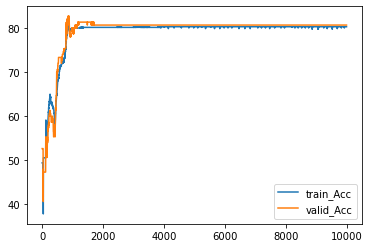

In [14]:
# plot accuracy curve
l1, = plt.plot(  range(1,n_iter+1), 100*train_accuracy_iter)
l2, = plt.plot(  range(1,n_iter+1), 100*valid_accuracy_iter)

plt.legend([l1, l2], ["train_Acc", "valid_Acc"])

## 4.2 Visualize classification

After training


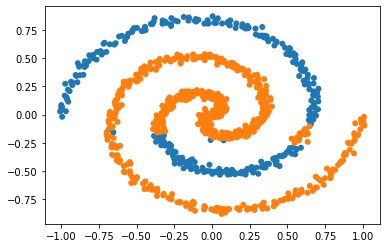

In [15]:
# visualizae classification result after training
print('After training')
prediction = my_classifier(data.permute(1, 0))
show_data(data, thresholding(prediction).permute(1, 0))

Text(0.5, 1.0, '(Pred) Test dataset')

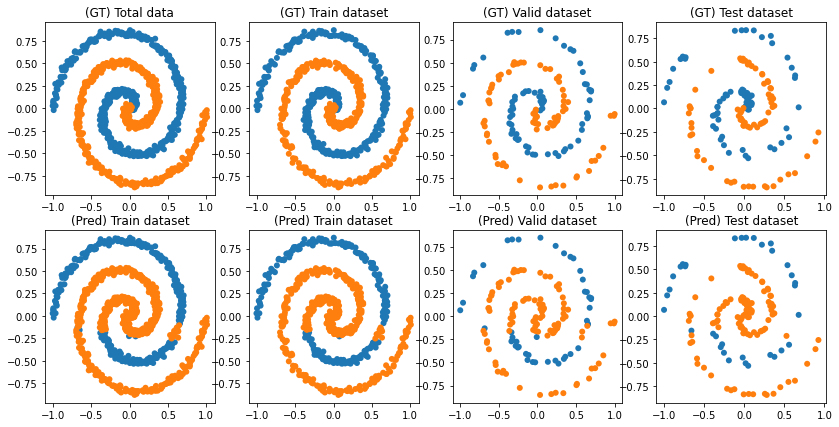

In [16]:
# show ground truth classification
plt.figure(figsize=[14, 7])
plt.subplot(2, 4, 1)
show_data(data, label)
plt.title("(GT) Total data")
plt.subplot(2, 4, 2)
show_data(train_data, train_label)
plt.title("(GT) Train dataset")
plt.subplot(2, 4, 3)
show_data(valid_data, valid_label)
plt.title("(GT) Valid dataset")
plt.subplot(2, 4, 4)
show_data(test_data, test_label)
plt.title("(GT) Test dataset")


plt.subplot(2, 4, 5)
show_data(data, thresholding(my_classifier(data.permute(1, 0))).permute(1, 0))
plt.title("(Pred) Train dataset")
plt.subplot(2, 4, 6)
show_data(train_data, thresholding(my_classifier(train_data.permute(1, 0))).permute(1, 0))
plt.title("(Pred) Train dataset")
plt.subplot(2, 4, 7)
show_data(valid_data, thresholding(my_classifier(valid_data.permute(1, 0))).permute(1, 0))
plt.title("(Pred) Valid dataset")
plt.subplot(2, 4, 8)
show_data(test_data, thresholding(my_classifier(test_data.permute(1, 0))).permute(1, 0))
plt.title("(Pred) Test dataset")

Let's feed the whole plane to visualize the decision boudary.

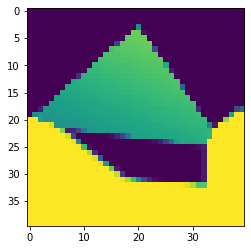

In [17]:
Xtest = np.mgrid[-1:1:0.05, -1:1:0.05].reshape(2,-1)
Xtest = torch.from_numpy(Xtest.T).float()

prediction = my_classifier.forward(Xtest).detach().numpy()
prediction_img = np.rot90(prediction.reshape(40, 40), k=1, axes=(0, 1))
plt.imshow(prediction_img)